Copyright (c) 2024 Giovanni Squillero <giovanni.squillero@polito.it>
https://github.com/squillero/computational-intelligence
Free for personal or classroom use; see LICENSE.md for details.

# Set Cover problem

Specifications of the problem : [https://en.wikipedia.org/wiki/Set_cover_problem](https://en.wikipedia.org/wiki/Set_cover_problem)

## Data

In [185]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import accumulate
from icecream import ic

UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

## Intialization

In [186]:
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

iterations = 10000

### Helper Functions

In [187]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## First solution

At first, I just wanted to have a minimal working hill climber to upgrade it later.

As discussed in class, we can define the fitness of a solution with this function :

In [188]:
def fitness(solution: np.ndarray) -> tuple[bool, int]:
    """"Return the fitness of a solution (to be maximized)"""
    return (valid(solution), -cost(solution))

We can then define a simple tweak that performs one random mutation on our solution :

In [189]:
def tweak(solution: np.ndarray) -> np.ndarray:
    """tweak function that perform one random mutation"""
    new_sol = solution.copy()
    index = np.random.randint(NUM_SETS)
    new_sol[index] = not new_sol[index]
    return new_sol

And finally define our first hill_climbing function for the set_cover problem :

In [190]:
def set_cover(initial_solution: np.ndarray) -> tuple[np.ndarray, list[int]] :
    """Perform a set_cover algorithm on a given initial solution"""
    solution = initial_solution.copy()
    history = [fitness(solution)[1]]
    for _ in range(iterations):
        test_solution = tweak(solution)
        history.append(fitness(test_solution)[1])
        if fitness(test_solution) > fitness(solution):
            solution = test_solution
    return solution, history

We define a simple starting point : take all of the sets. We must do it because if we start from an invalid solution, there is a huge probability that we don't end up with a valid one.

Let's run it and plot what the fitness of our solution look like.

ic| fitness(solution): (np.True_, np.float64(-136512.52461606392))


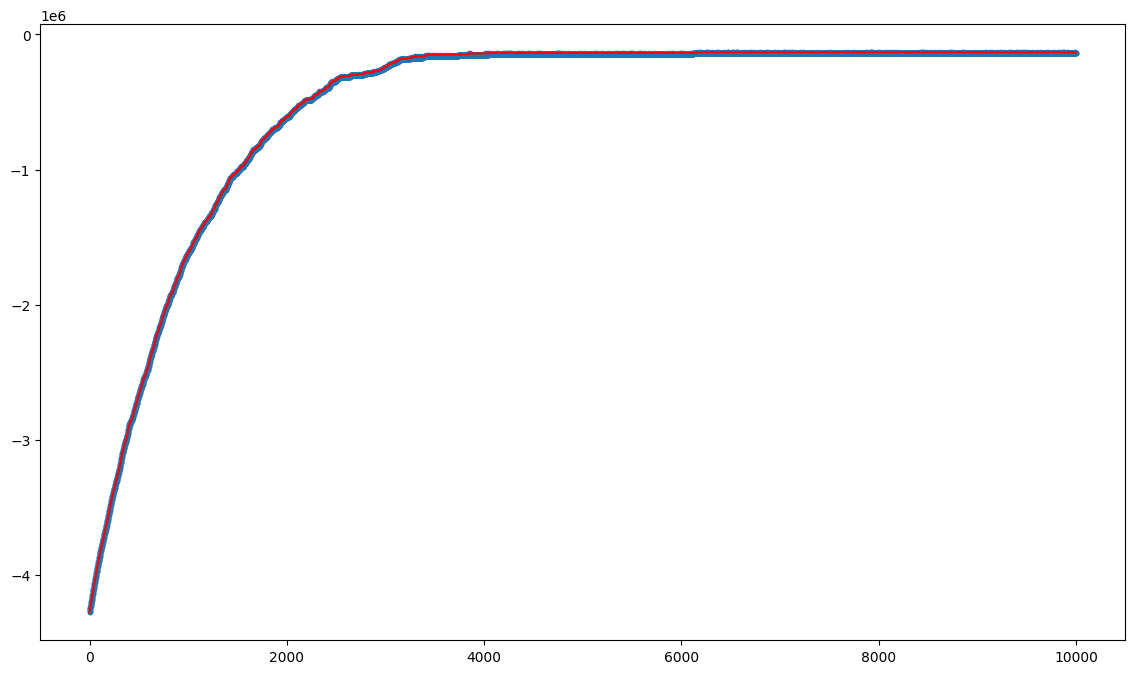

In [191]:
initial_solution = np.full(NUM_SETS, True)

solution, history = set_cover(initial_solution)

# Result
ic(fitness(solution))

# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

We can see that the algorithm climbs pretty slowly, in fact we are only on the exploitation of a solution and never on the exploration.

## Multiple random mutation

We can improve the tweak function to allow more large steps by performing multiple random mutations on the solution.

In [192]:
def tweak(solution: np.ndarray) -> np.ndarray:
    """tweak function that perform a mutation on n random index according to a probability"""
    mask = np.random.random(NUM_SETS) < 0.001
    new_sol = np.logical_xor(solution, mask)
    return new_sol

Since we do more large steps, we can update our initial_solution to be a random point on the fitness landscape. The probability of not having a valid solution at the end exists, but it's very very low.

Let's run it again and see what happens.

ic| fitness(solution): (np.True_, np.float64(-134638.5733834674))


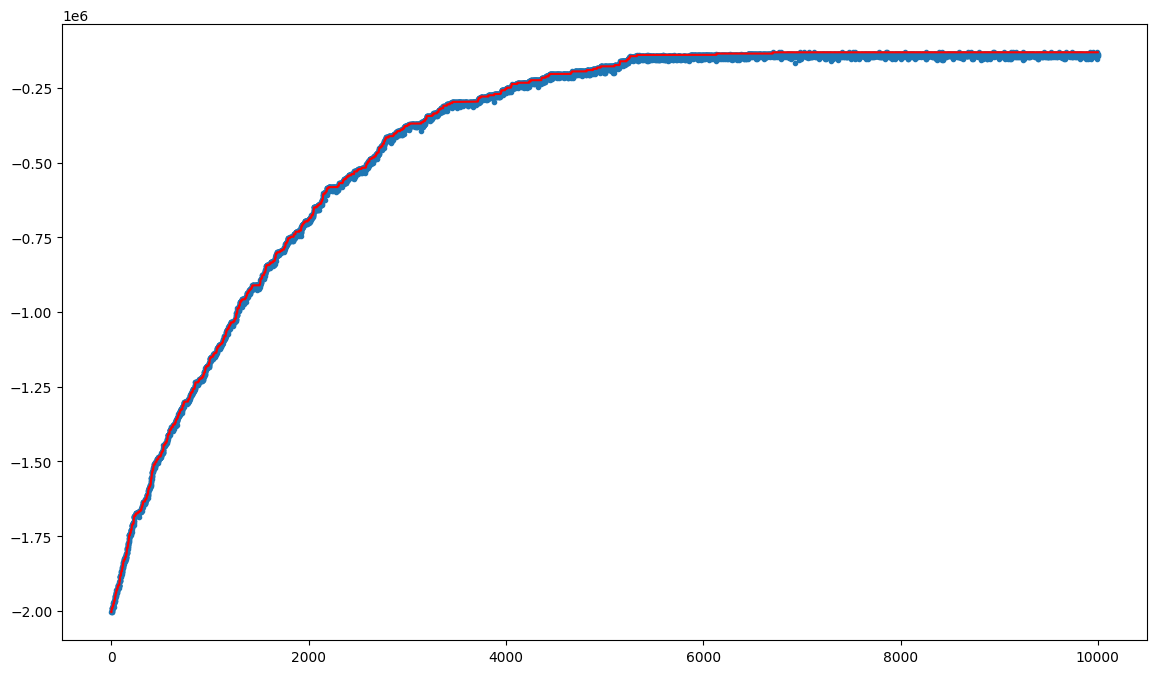

In [193]:
initial_solution = np.random.random(NUM_SETS) < .5

solution, history = set_cover(initial_solution)

# Result
ic(fitness(solution))


# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")



The result is a bit better in general. But the exploration takes still too much time.

## Multiple random mutation with a given strength

To be more efficient, what we can do is simply allowing more large steps at the beginning to improve exploration. Reduce the chance of taking more significant steps over time.

In [194]:
def tweak(solution: np.ndarray, strength: float) -> np.ndarray:
    """tweak function that perform a mutation on n random index according to a probability"""
    mask = np.random.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True 
    new_sol = np.logical_xor(solution, mask)
    return new_sol

Let's define the new set_cover algorithm that decreases the strength over time.

In [195]:
def set_cover(initial_solution: np.ndarray) -> tuple[np.ndarray, list[int]] :
    """Perform a set_cover algorithm on a given initial solution"""
    solution = initial_solution.copy()
    history = [fitness(solution)[1]]
    strength = 0.3
    for _ in range(iterations):
        strength*= 0.994
        test_solution = tweak(solution, strength)
        history.append(fitness(test_solution)[1])
        if fitness(test_solution) > fitness(solution):
            solution = test_solution
    return solution, history

ic| fitness(solution): (np.True_, np.float64(-132382.20233931078))


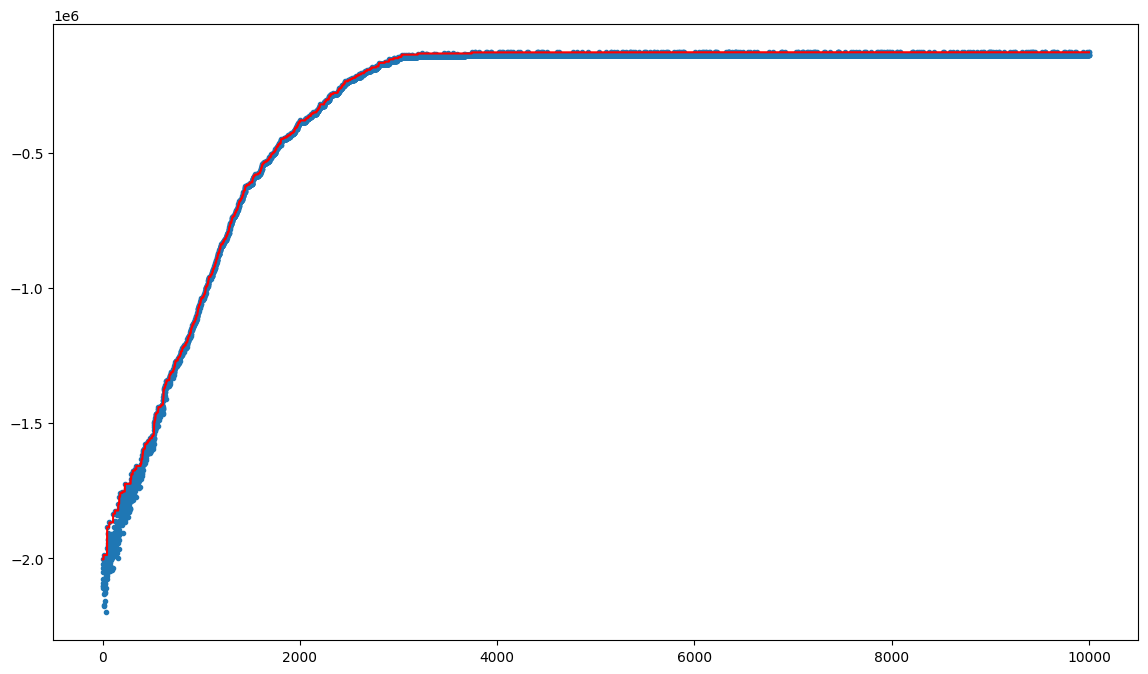

In [196]:
solution, history = set_cover(initial_solution)

# Result
ic(fitness(solution))

# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")


## Improvement of the hill climbing function

We always start from the bottom of the valids solutions, we can improve the algorithm by starting from a random position and also performing multiple times the algorithm to select the better one. We compare the local optimums.

ic| fitness(solution): (np.True_, np.float64(-123846.54084963088))


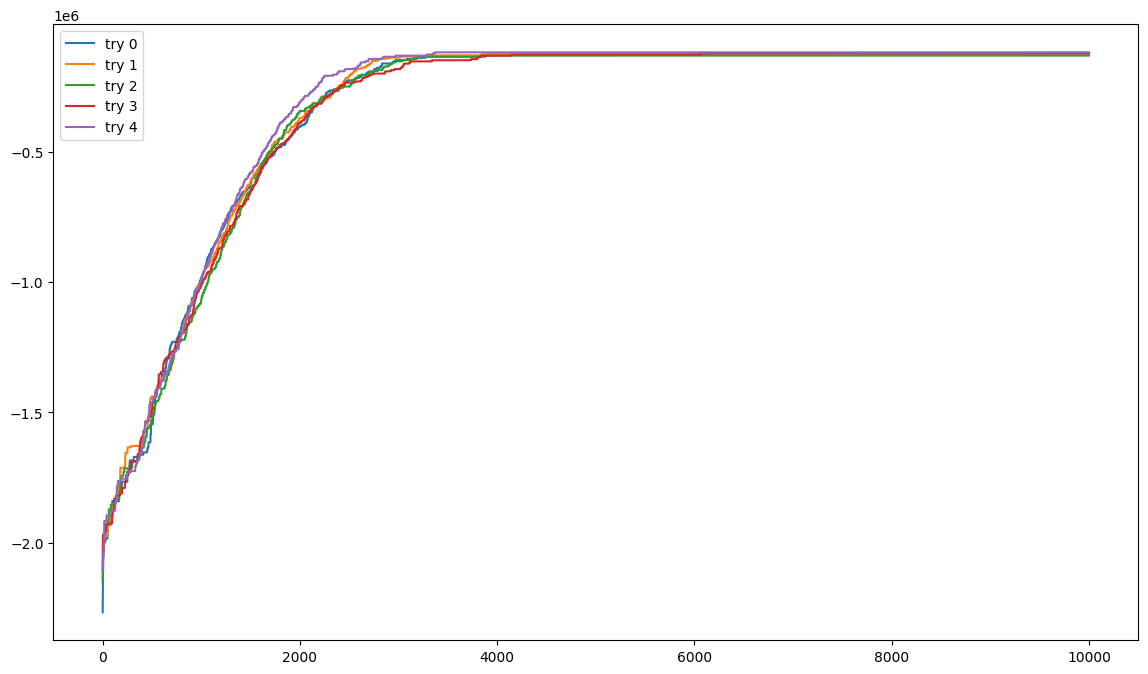

In [197]:
def multiple_set_cover():
    """Perform multiple time a set_cover algorithm and return the best one"""
    solution = np.random.random(NUM_SETS) < .5
    plt.figure(figsize=(14, 8))
    for i in range(5):
        new_solution = np.random.random(NUM_SETS) < .5
        new_solution, history = set_cover(new_solution)
        plt.plot(
            range(len(history)),
            list(accumulate(history, max)),
            label=f"try {i}"
        )
        if (fitness(new_solution) > fitness(solution)):
            solution = new_solution
    ic(fitness(solution))
    plt.legend()
    plt.show()
    return

iterations = 5000
multiple_set_cover()